In [1]:
import torch
import numpy as np
import torch.nn as nn

import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import argparse

In [2]:
torch.manual_seed(30)
np.random.seed(30)

epochs          = 3000         
learning_rate   = 0.002 
scheduler_step  = 30
scheduler_gamma = 0.1
sub             = 1
ntrain          = 90
ntest           = 10
T_in            = 50
T_end           = 350
S               = 104
batch_size      =  5
mode1           = 12
mode2           = 12
width           = 15
step            = 300

In [3]:
################################################################
# fourier layer
################################################################
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1/(self.in_channels*self.out_channels*1000)) # here 10 means the dx and dz
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))

        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft_x = torch.fft.rfft2(x)
        x_ft_z = torch.fft.rfft2(torch.transpose(x,2,3))

        # Multiply relevant Fourier modes
        out_ft_x = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, \
                             dtype=torch.cfloat, device=x.device)
        out_ft_z = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, \
                             dtype=torch.cfloat, device=x.device)
        out_ft_x[:, :, :self.modes1, :self.modes2]  = self.compl_mul2d(x_ft_x[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft_x[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft_x[:, :, -self.modes1:, :self.modes2], self.weights2)


        out_ft_z[:, :, :self.modes1, :self.modes2]  = self.compl_mul2d(x_ft_z[:, :, :self.modes1, :self.modes2], self.weights3)
        out_ft_z[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft_z[:, :, -self.modes1:, :self.modes2], self.weights4)

        #Return to physical space
        out_ft_x = torch.fft.irfft2(out_ft_x, s=(x.size(-2), x.size(-1)))
        out_ft_z = torch.fft.irfft2(out_ft_z, s=(x.size(-2), x.size(-1)))
        #print("this is the shape of the out_x", out_ft_x.shape)
        #print("this is the shape of the out_z", out_ft_z.shape)
        
        return out_ft_x, out_ft_z

In [4]:

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear((50+5), self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv6 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)


        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)

        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)
        self.bn5 = torch.nn.BatchNorm2d(self.width)
        self.bn6 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 300)
        #self.fc2 = nn.Linear(200, args.step)

    def forward(self, x , C1, C2, C3):
        batchsize = x.shape[0]

        size_x, size_y = x.shape[1], x.shape[2]

        C1 = torch.reshape(C1,[batchsize,1,size_x,size_y])
        C2 = torch.reshape(C2,[batchsize,1,size_x,size_y])
        C3 = torch.reshape(C3,[batchsize,1,size_x,size_y])

        C1 = torch.nn.functional.normalize(C1)
        C2 = torch.nn.functional.normalize(C2)
        C3 = torch.nn.functional.normalize(C3)

        C1 = torch.reshape(C1,[batchsize,size_x,size_y,1])
        C2 = torch.reshape(C2,[batchsize,size_x,size_y,1])
        C3 = torch.reshape(C3,[batchsize,size_x,size_y,1])

        grid = self.get_grid(batchsize, size_x, size_y, x.device)
        '''
        print("this is the shape of x",     x.shape)
        print("this is the shape of grid ", grid.shape)
        print("this is the shape of C1 ",   C1.shape)
        print("this is the shape of C2 ",   C2.shape)
        print("this is the shape of C3 ",   C3.shape)
        '''
        x = torch.cat((x, grid, C1, C2, C3), dim=-1)
        #print("this is the shape od x ",x.shape)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x0, z0 = self.conv0(x)
        xw_0   = self.w0(x)
        #print("this is the shape of the wx0", xw_0.shape)
        x      = self.bn0(xw_0 + x0 + z0 )
        x = F.relu(x)
        
        x1, z1 = self.conv1(x)
        xw_1   = self.w1(x)
        x      = self.bn1(xw_1 + x1 + z1 + x)
        x = F.relu(x)
        
        x2, z2 = self.conv2(x)
        xw_2   = self.w2(x)
        x      = self.bn2(xw_2 + x2 + z2 + x)
        x = F.relu(x)
        
        
        x3, z3 = self.conv3(x)
        xw_3   = self.w3(x)
        x      = self.bn3(xw_3 + x3 + z3 + x)
        x = F.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)

        return x

    def get_grid(self, batchsize, size_x, size_y, device):
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [5]:
def tensor_pad(input_tensor,npad, freeSurface,dtype):
    """
    This function is to padding velocity tensor for implementing the absorbing boudary condition.
        input_tensor: is a 3D tensor, shape=[1, self.in_channels, self.nz, self.nx]
        output_tensor: is also a 3D tensor, shape=[1, self.in_channels, self.nz_pad, self.nx_pad]
    """
    nz,nx = input_tensor.shape[0],input_tensor.shape[1]
    input_tensor = input_tensor.reshape(1,1,nz,nx)
    #print("this is input tensor shape", input_tensor.shape)

    nz_pad = nz + 2* npad
    nx_pad = nx + 2* npad
    in_channels = 1

    if freeSurface:
        vpadTop = input_tensor
    else:
        vtop = torch.ones((1, in_channels, npad, nx),dtype = dtype) * input_tensor[:,:,0,:]
        vpadTop = torch.cat((vtop,input_tensor), -2) #padding on axis=2 (nz)

    vbottom = torch.ones((1, in_channels, npad, nx),dtype = dtype) * input_tensor[:,:,-1,:]
    vpadBottom = torch.cat([vpadTop,vbottom], -2)#padding on axis=2 (nz)

    vleft = torch.ones((1, in_channels, nz_pad, npad),dtype = dtype) * \
    vpadBottom[:,:,:,0].view(1, in_channels, -1, 1)
    vpadLeft = torch.cat([vleft,vpadBottom], -1)#padding on axis=3 (nx)

    vright = torch.ones((1, in_channels, nz_pad, npad),dtype= dtype) * \
    vpadBottom[:,:,:,-1].view(1,in_channels, -1, 1)
    output_tensor = torch.cat([vpadLeft,vright], -1)#padding on axis=3 (nx)

    return output_tensor

In [9]:
TRAIN_PATH = 'E:\FNO_fields\FN_small_model_various_source'
vx_training = torch.load(TRAIN_PATH+'/vx_training_2022_0405.pt')

vp_index_training  = torch.load(TRAIN_PATH+'/vp_training_2022_0405.pt')
vs_index_training  = torch.load(TRAIN_PATH+'/vs_training_2022_0405.pt')
rho_index_training = torch.load(TRAIN_PATH+'/rho_training_2022_0405.pt')

print("this is the shape of the original size",vp_index_training.shape)
print("this is the shape of the fields",vx_training.shape)

vp_index_training  = vp_index_training[:,:,:].reshape(90,64,64,1)
vs_index_training  = vs_index_training[:,:,:].reshape(90,64,64,1)
rho_index_training = rho_index_training[:,:,:].reshape(90,64,64,1)



vx_testing = torch.load(TRAIN_PATH+'/vx_testing_2022_0405.pt')

vp_index_testing  = torch.load(TRAIN_PATH+'/vp_testing_2022_0405.pt')
vs_index_testing  = torch.load(TRAIN_PATH+'/vs_testing_2022_0405.pt')
rho_index_testing = torch.load(TRAIN_PATH+'/rho_testing_2022_0405.pt')

print("this is the shape of the original size",vp_index_testing.shape)
print("this is the shape of the fields",vx_testing.shape)

vp_index_testing  = vp_index_testing[:,:,:].reshape(10,64,64,1)
vs_index_testing  = vs_index_testing[:,:,:].reshape(10,64,64,1)
rho_index_testing = rho_index_testing[:,:,:].reshape(10,64,64,1)


this is the shape of the original size torch.Size([90, 64, 64, 1])
this is the shape of the fields torch.Size([90, 800, 104, 104])
this is the shape of the original size torch.Size([10, 64, 64, 1])
this is the shape of the fields torch.Size([10, 800, 104, 104])


In [10]:
vp_index_training_reshape   = torch.zeros(90,104,104)
vs_index_training_reshape   = torch.zeros(90,104,104)
rho_index_training_reshape  = torch.zeros(90,104,104)

vp_index_testing_reshape   = torch.zeros(10,104,104)
vs_index_testing_reshape   = torch.zeros(10,104,104)
rho_index_testing_reshape  = torch.zeros(10,104,104)


for i_model_index in range(90):
    vp_index_reshape_i = tensor_pad(vp_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    vp_index_training_reshape[i_model_index,:,:] = vp_index_reshape_i.squeeze()
    vs_index_reshape_i = tensor_pad(vs_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    vs_index_training_reshape[i_model_index,:,:] = vs_index_reshape_i.squeeze()
    rho_index_reshape_i = tensor_pad(rho_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    rho_index_training_reshape[i_model_index,:,:] = rho_index_reshape_i.squeeze()

for i_model_index in range(10):
    vp_index_reshape_i = tensor_pad(vp_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    vp_index_testing_reshape[i_model_index,:,:] = vp_index_reshape_i.squeeze()
    vs_index_reshape_i = tensor_pad(vs_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    vs_index_testing_reshape[i_model_index,:,:] = vs_index_reshape_i.squeeze()
    rho_index_reshape_i = tensor_pad(rho_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    rho_index_testing_reshape[i_model_index,:,:] = rho_index_reshape_i.squeeze()

In [11]:
vp_index_training_reshape =  vp_index_training_reshape.reshape(90,104,104,1)
vs_index_training_reshape =  vs_index_training_reshape.reshape(90,104,104,1)
rho_index_training_reshape = rho_index_training_reshape.reshape(90,104,104,1)

vp_index_testing_reshape =  vp_index_testing_reshape.reshape(10,104,104,1)
vs_index_testing_reshape =  vs_index_testing_reshape.reshape(10,104,104,1)
rho_index_testing_reshape = rho_index_testing_reshape.reshape(10,104,104,1)

In [12]:
runtime = np.zeros(2, )
t1 = default_timer()

In [13]:
print("this is the shape of vx_train", vx_training.shape)
#print("this is the shape of vx_train", vz_train.shape)
vx_training = vx_training.permute(0,2,3,1)
vx_testing  = vx_testing.permute(0,2,3,1)

print(vx_training.shape)
print(vx_testing.shape)

this is the shape of vx_train torch.Size([90, 800, 104, 104])
torch.Size([90, 104, 104, 800])
torch.Size([10, 104, 104, 800])


In [14]:
train_a = vx_training[:,::sub,::sub,:T_in]
train_u = vx_training[:,::sub,::sub,T_in:T_end]

train_vp  =  vp_index_training_reshape[:,::sub,::sub,:]
train_vs  =  vs_index_training_reshape[:,::sub,::sub,:]
train_rho  = rho_index_training_reshape[:,::sub,::sub,:]

test_a  = vx_testing[:,::sub,::sub,:T_in]
test_u  = vx_testing[:,::sub,::sub,T_in:T_end]

test_vp  = vp_index_testing_reshape [:,::sub,::sub,:]
test_vs  = vs_index_testing_reshape [:,::sub,::sub,:]
test_rho = rho_index_testing_reshape[:,::sub,::sub,:]

In [15]:
print("this is the training_set of of a", train_a.shape)
print("this is the training_set of of u", train_u.shape)
print("this is the training_set of of vp",  train_vp.shape)
print("this is the training_set of of vs",  train_vs.shape)
print("this is the training_set of of rho", train_rho.shape)

print("this is the testing_set of of a", test_a.shape)
print("this is the testing_set of of u", test_u.shape)

print("this is the testing_set of of vp",  test_vp.shape)
print("this is the testing_set of of vs",  test_vs.shape)
print("this is the testing_set of of rho", test_rho.shape)

this is the training_set of of a torch.Size([90, 104, 104, 50])
this is the training_set of of u torch.Size([90, 104, 104, 300])
this is the training_set of of vp torch.Size([90, 104, 104, 1])
this is the training_set of of vs torch.Size([90, 104, 104, 1])
this is the training_set of of rho torch.Size([90, 104, 104, 1])
this is the testing_set of of a torch.Size([10, 104, 104, 50])
this is the testing_set of of u torch.Size([10, 104, 104, 300])
this is the testing_set of of vp torch.Size([10, 104, 104, 1])
this is the testing_set of of vs torch.Size([10, 104, 104, 1])
this is the testing_set of of rho torch.Size([10, 104, 104, 1])


In [16]:
print(train_u.shape)
assert (S            == train_u.shape[-2])
assert (300          == train_u.shape[-1])

assert (S            == test_u.shape[-2])
assert (300          == test_u.shape[-1])

assert (S == train_vp.shape[-2])
assert (S == train_vs.shape[-2])
assert (S == train_rho.shape[-2])

assert (S == test_vp.shape[-2])
assert (S == test_vs.shape[-2])
assert (S == test_rho.shape[-2])

torch.Size([90, 104, 104, 300])


In [17]:
train_a = train_a.reshape(90, S, S, 50)
train_u = train_u.reshape(90, S, S, 300)
test_a  = test_a.reshape (10, S, S, 50)
test_u  = test_u.reshape (10, S, S, 300)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


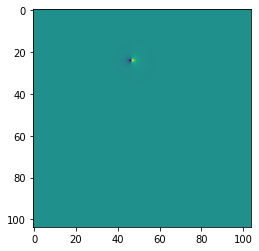

In [18]:
plt.imshow(test_a[2,:,:,30])
print(test_a[2,:,:,30])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.1248e-35,
          1.5185e-36, -3.2196e-37],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.5020e-34,
          2.9720e-35,  2.8504e-37],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -9.8241e-34,
         -2.1967e-34,  2.1015e-35],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


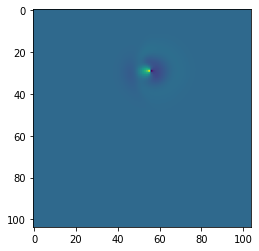

In [19]:
plt.imshow(test_u[9,:,:,30])
print(test_u[9,:,:,30])

In [20]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u,\
                                                                          train_vp,train_vs,train_rho), \
                                                                          batch_size = batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u, \
                                                                          test_vp,test_vs,test_rho), \
                                                                          batch_size = batch_size, shuffle=True)

In [21]:
device = torch.device('cuda')
print("this is the devide we are using device \n", device)
model = FNO2d(mode1, mode2, width).cuda()

this is the devide we are using device 
 cuda


In [22]:
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

training_loss_tensor = torch.zeros(epochs)
testing_loss_tensor  = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
costFunc = torch.nn.MSELoss(reduction='sum')
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step_training = 0
    test_l2_step_testing = 0
    for xx, yy, C1, C2, C3 in train_loader:
        #print("this the the loading of training loader")
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)
        C1 = C1.to(device)
        C2 = C2.to(device)
        C3 = C3.to(device)

        for t in range(0, (T_end - T_in),step):
            y = yy[..., t:t + step]
            #print("this is the shape of y",y.shape)
            im_train = model(xx,C1,C2,C3)
            #loss += costFunc(im_train,y)
            loss += myloss(im_train.reshape(batch_size, -1), y.reshape(batch_size, -1))
            if t == 0:
                pred = im_train
            else:
                pred = torch.cat((pred, im_train), -1)

            xx = torch.cat((xx[..., step:], im_train), dim=-1)

            #print("this is the shape of xx ======>", xx.shape)
        #print("this before loss backpropagation")
        train_l2_step_training += loss.item()
        #l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        #train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        #print("this is the loss ====== >", loss)
        #print("this is the epoch====== >", ep)
        optimizer.step()
        training_loss_tensor[ep] = train_l2_step_training

    test_l2_step = 0
    test_l2_full = 0
    
    with torch.no_grad():
        for xx, yy, C1, C2, C3 in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            C1 = C1.to(device)
            C2 = C2.to(device)
            C3 = C3.to(device)

            for t in range(0, (T_end - T_in),step):
                y = yy[..., t:t + step]
                im_test = model(xx,C1,C2,C3)
                #loss += costFunc(im_test,y)
                loss += myloss(im_test.reshape(batch_size, -1), y.reshape(batch_size, -1))
                if t == 0:
                    pred = im_test
                else:
                    pred = torch.cat((pred, im_test), -1)

                xx = torch.cat((xx[..., step:], im_test), dim=-1)

            test_l2_step_testing += loss.item()
            #test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
            testing_loss_tensor[ep] = test_l2_step_testing

    t2 = default_timer()
    #scheduler.step()
    print("current epock",ep, \
          "processing time in each iteration [{:.4e}]".format(t2 - t1), \
          "training loss [{:.4e}]".format(train_l2_step_training), \
          "testing loss  [{:.4e}]".format(test_l2_step_testing))

14563320
current epock 0 processing time in each iteration [2.9361e+01] training loss [6.8501e+02] testing loss  [2.8065e+01]
current epock 1 processing time in each iteration [1.8307e+00] training loss [1.7708e+02] testing loss  [1.4408e+01]
current epock 2 processing time in each iteration [1.7504e+00] training loss [1.1365e+02] testing loss  [1.1462e+01]
current epock 3 processing time in each iteration [1.7155e+00] training loss [9.8702e+01] testing loss  [1.0634e+01]
current epock 4 processing time in each iteration [1.6876e+00] training loss [9.4300e+01] testing loss  [1.0394e+01]
current epock 5 processing time in each iteration [1.7103e+00] training loss [9.2958e+01] testing loss  [1.0242e+01]
current epock 6 processing time in each iteration [1.7038e+00] training loss [9.2030e+01] testing loss  [1.0216e+01]
current epock 7 processing time in each iteration [1.7470e+00] training loss [9.1834e+01] testing loss  [1.0845e+01]
current epock 8 processing time in each iteration [1.73

In [23]:
torch.save(testing_loss_tensor,   TRAIN_PATH+'/testing_loss_OCFNO_tensor_2022_0405_'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')
torch.save(training_loss_tensor,  TRAIN_PATH+'/training_loss_OCFNO_tensor_2022_0405_'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')
torch.save(model.state_dict(),    TRAIN_PATH+'/model_OCFNO_tensor_2022_0405_'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')

In [24]:
im_plot_train  = im_train[2,:,:,200].cpu().clone().detach().numpy()
im_plot_tests  = im_test [3,:,:,100].cpu().clone().detach().numpy()

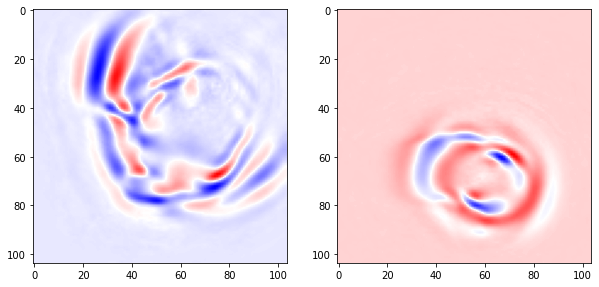

In [25]:
fig = plt.figure(figsize = (10,10)) # create the canvas for plotting
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(im_plot_train, cmap='bwr_r')
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(im_plot_tests, cmap='bwr_r')

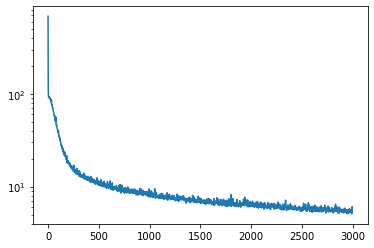

In [26]:
plt.plot(training_loss_tensor)
plt.yscale('log')

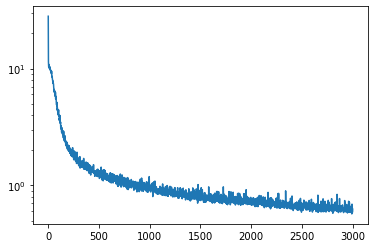

In [27]:
plt.plot(testing_loss_tensor)
plt.yscale('log')